# I. Mirror number classification
### 1) MLP (multilayer perceptron) network

*Based on: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/*

Here we implement our first ML model for the basic task of classifying the number of mirrors in the system, based on the interference pattern. We start with a simple deep neural network - an MLP - which consists of several fully connected layers. 

In [5]:
# necessary imports

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from numpy import loadtxt
import numpy as np
import matplotlib.pyplot as plt

The input data is in the form of a CSV file, where each row has numbers separated by commas. The first value signifies the number of mirrors present in the system; subsequent numbers are the values of total transmittance for equally spaced wavenumbers k. The number of k values is constant through all the rows and depends on the generated data - the more k values, the more dense the probing of the k-space.

Let us load the dataset and visualize some interference pattern.

In [6]:
dataset = loadtxt('data50.csv', delimiter=',', skiprows=1)

# number of k samples
k_samples = 50

# number of classes (of mirror number)
num_classes = 8

# list of class labels
classes = [f'{class_id}' for class_id in range(3, 11)]

# mirror numbers (the correct classes) in the first column
y = dataset[:,0]

# convenient to have the classes starting from 0, so just subtract 3 from every y
y -= 3

# transmittance values
X = dataset[:,1:]

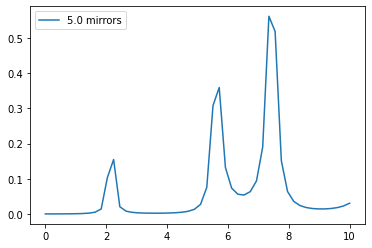

In [7]:
# k-space for plotting
kmin = 0
kmax = 10
ks = np.linspace(kmin, kmax, k_samples)

which_row = 10000

plt.figure()
plt.plot(ks, X[which_row], label=f'{y[which_row]+3} mirrors')
plt.legend(loc='best')
plt.show()

We will now split the dataset randomly into the training and test parts, borrowing a function from the scikit-learn package.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y, 
                                                    test_size = 0.25,
                                                    random_state = 42)

# the 'stratify = y' argument ensures that the training and testing sets contain the same proportion of each class
# we especially need to watch out for this for the lowest number of mirrors 
# which forms a tiny proportion of the whole dataset:

print('Proportion of 3-mirror elements in the testing set:', list(y_test).count(0) / len(y_test))
print('Proportion of 3-mirror elements in the testing set:', list(y_train).count(0) / len(y_train))

Proportion of 3-mirror elements in the testing set: 0.0018492804028186927
Proportion of 3-mirror elements in the testing set: 0.00184928440263788


Checks out. Let us build the network now (with the sizes of hidden layers chosen arbitrarily).

In [9]:
# Define the model
model = Sequential()
model.add(Dense(24, input_dim=k_samples, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='sigmoid'))

# The last layer consists of 8 nodes as we generated the data for 3 to 10 mirrors.

We shall define metrics to gauge the performance of our model using a useful function from the sklearn module. To have it evaluated after each epoch of the training, we will wrap it in a Keras callback. This callback will evaluate the classification report and log it to a log dictionary.

In [10]:
from sklearn.metrics import classification_report

classification_report_log_dict = {**{f'{class_id}' : {'precision': [], 'recall': [], 'f1-score': []} 
                                  for class_id in range(3, 11)}, **{'accuracy': [], 
                                        'macro avg': {'precision': [], 'recall': [], 'f1-score': []},
                                        'weighted avg': {'precision': [], 'recall': [], 'f1-score': []}}}


class PerformanceEvaluationCallback(keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        self.x_test = x_test
        self.y_test = y_test
        
    def on_epoch_end(self, epoch, logs=None):
        print('Evaluating the model...', end = ' ')
        y_pred = self.model.predict(self.x_test, verbose=0, batch_size = len(self.x_test))
        y_pred = np.argmax(y_pred, axis = 1)
        report = classification_report(self.y_test, y_pred, 
                              target_names = ['3','4','5','6','7','8','9','10'], output_dict = True)
        for class_id in classes + ['macro avg', 'weighted avg']:
            classification_report_log_dict[class_id]['precision'].append(report[class_id]['precision'])
            classification_report_log_dict[class_id]['recall'].append(report[class_id]['recall'])
            classification_report_log_dict[class_id]['f1-score'].append(report[class_id]['f1-score'])
        
        classification_report_log_dict['accuracy'].append(report['accuracy'])
        print(f"Accuracy: {report['accuracy']}")

        
        
performance_callback = PerformanceEvaluationCallback(X_test, y_test)

Now we compile.

In [11]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

Set necessary prerequisites and train, using the testing data for validation.

In [12]:
epochs = 100
batch_size = 32

callbacks = [
    performance_callback,
    
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/100
14449/14449 [==============================] - 12s 797us/step - loss: 1.1570 - val_loss: 1.0028
Evaluating the model... Accuracy: 0.5522470379070039
Epoch 2/100
14449/14449 [==============================] - 12s 810us/step - loss: 0.9072 - val_loss: 0.8351
Evaluating the model... Accuracy: 0.63284321995406
Epoch 3/100
14449/14449 [==============================] - 13s 875us/step - loss: 0.7602 - val_loss: 0.7155
Evaluating the model... Accuracy: 0.6764473052415744
Epoch 4/100
14449/14449 [==============================] - 11s 746us/step - loss: 0.6452 - val_loss: 0.5916
Evaluating the model... Accuracy: 0.725054180671451
Epoch 5/100
14449/14449 [==============================] - 11s 790us/step - loss: 0.5633 - val_loss: 0.5104
Evaluating the model... Accuracy: 0.7705010576586163
Epoch 6/100
14449/14449 [==============================] - 11s 755us/step - loss: 0.4964 - val_loss: 0.5051
Evaluating the model... Accuracy: 0.7684052065354219
Epoch 7/100
14449/14449 [============

Evaluating the model... Accuracy: 0.8739634296689464
Epoch 52/100
14449/14449 [==============================] - 10s 708us/step - loss: 0.0871 - val_loss: 0.1036
Evaluating the model... Accuracy: 0.8757997326654295
Epoch 53/100
14449/14449 [==============================] - 10s 683us/step - loss: 0.0859 - val_loss: 0.0882
Evaluating the model... Accuracy: 0.8742294664988255
Epoch 54/100
14449/14449 [==============================] - 10s 689us/step - loss: 0.0854 - val_loss: 0.0986
Evaluating the model... Accuracy: 0.8818731588304761
Epoch 55/100
14449/14449 [==============================] - 11s 752us/step - loss: 0.0831 - val_loss: 0.0623
Evaluating the model... Accuracy: 0.8865839573302879
Epoch 56/100
14449/14449 [==============================] - 11s 795us/step - loss: 0.0834 - val_loss: 0.1058
Evaluating the model... Accuracy: 0.8677472520342084
Epoch 57/100
14449/14449 [==============================] - 12s 802us/step - loss: 0.0834 - val_loss: 0.2115
Evaluating the model... Accu

The best model is saved and can be recovered with the following line:

In [9]:
#model = keras.models.load_model("best_model.h5")

Let us now plot the history of training.

In [216]:
import matplotlib.cm as cm
cmap = cm.get_cmap('turbo')
colors = [cmap(i/7.) for i in range(8)]

First, the overall accuracy and averages of the class-dependent metrics: precision, recall and the F1 score (without weighting by the classes' population). Then, class-wise: precision, recall and the f1-score.

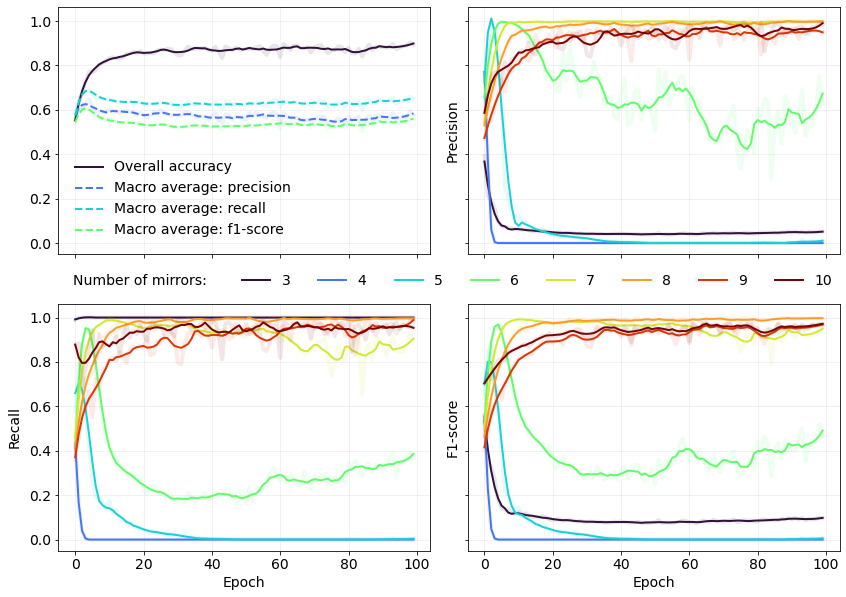

In [228]:
from scipy.signal import savgol_filter # for curve-smoothing
def smooth_plot(ax, data, window_size = 11, poly_order = 3, **kwargs):
    avg_data = savgol_filter(data, window_size, poly_order) # data to smooth, smoothing window size, polynomial order used in the filter
    
    ax.plot(data, alpha = 0.1, linewidth = 4, color = kwargs['color'])
    ax.plot(avg_data, linewidth = 2, **kwargs)

#####################
### ACCURACY PLOT ###
#####################
    
fig, ax = plt.subplots(2, 2, figsize=(14,10), sharex = True, sharey = True)
plt.rcParams['font.size'] = '14'

#ax[0,0].set_xlabel("Epoch")
smooth_plot(ax[0,0], classification_report_log_dict['accuracy'], label = 'Overall accuracy', color = colors[0])

smooth_plot(ax[0,0], classification_report_log_dict['macro avg']['precision'], 
         label = 'Macro average: precision', linestyle='--', color = colors[1])
smooth_plot(ax[0,0], classification_report_log_dict['macro avg']['recall'], 
         label = 'Macro average: recall', linestyle='--', color = colors[2])
smooth_plot(ax[0,0], classification_report_log_dict['macro avg']['f1-score'], 
         label = 'Macro average: f1-score', linestyle='--', color = colors[3])


ax[0,0].legend(loc='lower left', frameon = False, borderpad = 0.7)
ax[0,0].grid(alpha=0.2)

######################
### PRECISION PLOT ###
######################

metric = "Precision"
ax[0,1].set_ylabel(metric, labelpad = 8)
#ax[0,1].set_xlabel("Epoch")

for class_id, col in zip(classes, colors):
    class_metric = metric + ": " + class_id + " mirrors"
    if class_id == '4':
        smooth_plot(ax[0,1], classification_report_log_dict[class_id]['precision'], window_size = 3, poly_order = 2,
             label = class_id, color=col)
    else:
        smooth_plot(ax[0,1], classification_report_log_dict[class_id]['precision'], 
             label = class_id, color=col)
    
#ax[0,1].legend(loc='right',  bbox_to_anchor=[0.95, 0.3], title='Number of mirrors', ncol=3, frameon = False)
ax[0,1].grid(alpha=0.2)

###################
### RECALL PLOT ###
###################

metric = "Recall"
ax[1,0].set_ylabel(metric, labelpad = 8)
ax[1,0].set_xlabel("Epoch")

for class_id, col in zip(classes, colors):
    class_metric = metric + ": " + class_id + " mirrors"
    if class_id == '4':
        smooth_plot(ax[1,0], classification_report_log_dict[class_id]['recall'], window_size = 3, poly_order = 2,
             label = class_id, color=col)
    else:    
        smooth_plot(ax[1,0], classification_report_log_dict[class_id]['recall'], 
             label = class_id, color=col)

#ax[1,0].legend(loc='right',  bbox_to_anchor=[0.95, 0.6], title='Number of mirrors', ncol=3, frameon = False)
ax[1,0].grid(alpha=0.2)

#####################
### F1-SCORE PLOT ###
#####################

metric = "F1-score"
ax[1,1].set_ylabel(metric, labelpad=8)
ax[1,1].set_xlabel("Epoch")

for class_id, col in zip(classes, colors):
    class_metric = metric + ": " + class_id + " mirrors"
    if class_id == '4':
        smooth_plot(ax[1,1], classification_report_log_dict[class_id]['f1-score'], window_size = 3, poly_order = 2,
             label = class_id, color=col)
    else:    
        smooth_plot(ax[1,1], classification_report_log_dict[class_id]['f1-score'], 
                 label = class_id, color=col)
    
#ax[1,1].legend(loc='right',  bbox_to_anchor=[0.95, 0.6], title='Number of mirrors', ncol=3, frameon = False)
ax[1,1].grid(alpha=0.2)

handles, labels = plt.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())

fig.text(0.14, 0.5, 'Number of mirrors:', va = 'center')
fig.legend(handles, labels, bbox_to_anchor=[0.6, 0.5], loc='center', ncol=8, frameon = False)

plt.subplots_adjust(wspace = 0.1)
#plt.tight_layout()
plt.savefig('mlp1.pdf')
plt.show()

For completeness and convenience, we also output the final classification report in text form.

In [192]:
y_pred = model.predict(X_test, batch_size=len(X_test), verbose=1)
y_test_check = y_test
y_pred_check = np.argmax(y_pred, axis = 1)
print(classification_report(y_test_check, y_pred_check, target_names = classes))



1/1 [==============================] - 0s 250ms/step
              precision    recall  f1-score   support

           3       0.05      1.00      0.10       285
           4       0.00      0.00      0.00      1211
           5       0.01      0.01      0.01      3876
           6       0.62      0.37      0.46      9690
           7       1.00      0.89      0.94     19380
           8       1.00      1.00      1.00     31493
           9       0.95      0.98      0.97     41990
          10       0.98      0.96      0.97     46189

    accuracy                           0.89    154114
   macro avg       0.58      0.65      0.55    154114
weighted avg       0.92      0.89      0.90    154114



History for future reference and plotting:

In [193]:
print(classification_report_log_dict)


{'3': {'precision': [0.39221140472878996, 0.21142433234421365, 0.19256756756756757, 0.1574585635359116, 0.09687287559483344, 0.07715213860314023, 0.07130347760820616, 0.07050964868876794, 0.06607929515418502, 0.061119450997212096, 0.06618671620993961, 0.05935027072053311, 0.06269247690277167, 0.056863527533918594, 0.05374316424665284, 0.0541104993354851, 0.052236070381231674, 0.0561576354679803, 0.05373303167420815, 0.04695222405271829, 0.04595291841341503, 0.04775469168900804, 0.04803640653969324, 0.04447565543071161, 0.04551988500239578, 0.046698345076192034, 0.04461490294301816, 0.04188712522045855, 0.04386639987686625, 0.04141839848859177, 0.04129836255615128, 0.04212860310421286, 0.04206021251475797, 0.04173989455184534, 0.04153308073447974, 0.04043126684636118, 0.0398267188373393, 0.04026561175473298, 0.042122376588826484, 0.04105445116681072, 0.04267105854169786, 0.04065620542082739, 0.039960740325294446, 0.04069103369503141, 0.04005621925509487, 0.04186866460996033, 0.039153729